# This script calcualtes Climate Velocity in the vertical dimension across the Norteast US Shelf
PART I: ROMS
1. Load the ROMS data
2. Calculate the temperature trend as the slope of the linear regression
3. Calculate the p-values for those linear regressions
4. Calculates the spatial gradient in the vertical
5. Load the shapefiles for the EPUs
6. Crop spatgrad and temptrend to EPU areas
7. Calculate climate velocities
8. Make plots

PART 2. GLORYS
* Does the same as above but using GLORYS reanalysis

In [1]:
# Import packages needed
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import matplotlib
from numpy.ma import masked_invalid
from scipy.stats import linregress

In [2]:
# Load the roms data
roms = xr.open_dataset('roms_converted_temp5m_whole_domain.nc')

In [ ]:
# calculate the temperature trend at each grid point and determine significance with p-values

slopes = np.empty([242,106,61])
p_vals = np.empty([242,106,61])
x = np.arange(0,len(roms.ocean_time[:]))
for i in range(242):
    for j in range(106):
        for k in range(61):
            y = roms.temp_5m[i,j,k,:]
            LR = linregress(x, y)
            slopes[i,j,k] = LR.slope
            p_vals[i,j,k] = LR.pvalue
    #print(i)

In [ ]:
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

ROMS_slice_mean = np.nanmean(roms.temp_5m[:,:,:,:],3)
UD_net = np.empty([242,106,61])
UD_net[:,:,:] = np.nan

for i in range(242):
    for j in range(106):
        for k in range(60):
            if k == 59: #at the surface
                focal_temp = ROMS_slice_mean[i,j,k]
                DO_grad = -1*(focal_temp - ROMS_slice_mean[i,j,k-1])/DOWN # angle = 0
                UD_net[i,j,k] = DO_grad
            if k == 0: #at the bottom
                focal_temp = ROMS_slice_mean[i,j,k]
                UP_grad = (focal_temp - ROMS_slice_mean[i,j,k+1])/DOWN # angle = 180
                UD_net[i,j,k] = UP_grad
            if k >0 and k < 59:
                focal_temp = ROMS_slice_mean[i,j,k]
                UP_grad = (focal_temp - ROMS_slice_mean[i,j,k+1])/UP # angle = 0
                DO_grad = -1*((focal_temp - ROMS_slice_mean[i,j,k-1])/DOWN) # angle = 180
                if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                    UD_net[i,j,k] = np.nan
                else:
                    UD_net[i,j,k] = np.nansum([UP_grad, DO_grad])

In [3]:
# Function for cropping data to EPU area
def inSHAPE_all_depth(longitude, latitude, depth, var, shape):
    x = longitude
    y = latitude
    empty = np.empty([242, 106, len(depth)])
    empty[:,:,:] = np.nan
    for i in range(242):
        for j in range(106):
            if Point(x[i,j], y[i,j]).within(shape) == True:
                empty[i,j,:] = var[i,j,:]
    return empty

In [177]:
# Load EPU shapefile
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
EPU = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/EPU_NOESTUARIES.shp')
MAB = EPU[EPU.EPU == 'MAB']
GOM = EPU[EPU.EPU == 'GOM']
GB = EPU[EPU.EPU == 'GB']
ScS = EPU[EPU.EPU == 'SS']
MAB_shape = MAB.geometry[0]
GOM_shape = GOM.geometry[1]
GB_shape = GB.geometry[3]
SS_shape = ScS.geometry[2]

In [ ]:
# Crop temperature trends to EPU shapes
slopeMAB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], slopes, MAB_shape)
slopeGOM = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], slopes, GOM_shape)
slopeGB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], slopes, GB_shape)
slopeSS = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], slopes, SS_shape)

In [ ]:
# Crop p-values to EPU shapes
pvalMAB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], p_vals, MAB_shape)
pvalGOM = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], p_vals, GOM_shape)
pvalGB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], p_vals, GB_shape)
pvalSS = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], p_vals, SS_shape)

In [ ]:
# Crop spatgrad to EPU shapes
sgMAB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], UD_net, MAB_shape)
sgGOM = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], UD_net, GOM_shape)
sgGB = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], UD_net, GB_shape)
sgSS = inSHAPE_all_depth(roms['lon_rho'], roms['lat_rho'],roms['depth2'], UD_net, SS_shape)

In [ ]:
pvalMAB_yn = pvalMAB
pvalMAB_yn[np.where(pvalMAB_yn>0.05)] = np.nan
pvalMAB_yn[np.where(pvalMAB_yn<=0.05)] = 1

In [ ]:
pvalGOM_yn = pvalGOM
pvalGOM_yn[np.where(pvalGOM_yn>0.05)] = np.nan
pvalGOM_yn[np.where(pvalGOM_yn<=0.05)] = 1

In [ ]:
pvalGB_yn = pvalGB
pvalGB_yn[np.where(pvalGB_yn>0.05)] = np.nan
pvalGB_yn[np.where(pvalGB_yn<=0.05)] = 1

In [ ]:
pvalSS_yn = pvalSS
pvalSS_yn[np.where(pvalSS_yn>0.05)] = np.nan
pvalSS_yn[np.where(pvalSS_yn<=0.05)] = 1

In [462]:
#Calculates the along transect distance in meters
dist = np.empty([106,242])
dist[:] = np.nan
dist[0,:] = 0 
import math
R = 6373.0 #radius of the Earth
D = 0
for j in range(241):
    D = 0
    for i in range(105):
        lat1 = np.radians(roms.lat_rho[j,i]) #coordinates
        lon1 = np.radians(roms.lon_rho[j,i])

        lat2 = np.radians(roms.lat_rho[j,i+1])
        lon2 = np.radians(roms.lon_rho[j,i+1])

        dlon = lon2 - lon1 #change in coordinates
        dlat = lat2 - lat1

        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2 #Haversine formula
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = (R * c)*1000
    
        D = D + distance
        dist[i+1,j] = D

In [ ]:
def TempTrendPlot(transect_index, start_index, stop_index, slope_var, pval_var, line_letter):
    i=stop_index
    j=transect_index
    k=start_index
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist[k:i,0]/1000, -1*roms.depth2[40:-1], (slope_var[j,k:i,40:-1]*12).T, cmap = 'seismic',  levels = np.arange(0.05, 0.28, 0.01),extend = 'both')
    string = 'DegC/year line ' + line_letter
    plt.gca().invert_yaxis()
    c2 = ax.contourf(dist[k:i,0]/1000, -1*roms.depth2[40:-1], pval_var[j,k:i,40:-1].T, hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)


In [ ]:
def SpatGradPlot(transect_index, start_index, stop_index, spatgrad_var, line_letter):
    i=stop_index
    j=transect_index
    k=start_index
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist[k:i,0]/1000, -1*roms.depth2[40:-1], (spatgrad_var[j,k:i,40:-1]).T, cmap = 'viridis',  levels = np.arange(-0.55, 0.025, 0.025),extend = 'both')
    ax.contour(dist[k:i,0]/1000, -1*roms.depth2[40:-1], (spatgrad_var[j,k:i,40:-1]).T, color='k',  levels = [0])
    string = 'DegC/m line ' + line_letter
    plt.gca().invert_yaxis()
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

In [ ]:
def ClimVelPlot(transect_index, start_index, stop_index, spatgrad_var, slope_var, pval_var, line_letter):
    i=stop_index
    j=transect_index
    k=start_index
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist[k:i,0]/1000, -1*roms.depth2[40:-1], ((slope_var[j,k:i,40:-1]*12)/(spatgrad_var[j,k:i,40:-1])).T, cmap = 'magma',  levels = np.arange(-5, 0, 0.25),extend = 'both')
    c2 = ax.contourf(dist[k:i,0]/1000, -1*roms.depth2[40:-1], pval_var[j,k:i,40:-1].T, hatches=['.'],alpha=0.0)
    ax.contour(dist[k:i,0]/1000, -1*roms.depth2[40:-1], ((slope_var[j,k:i,40:-1]*12)/(spatgrad_var[j,k:i,40:-1])).T, colors='g',  levels = [0])
    string = 'm/year line ' + line_letter
    plt.gca().invert_yaxis()
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

In [3]:
lineA_lat = roms.lat_rho[50,50:67]
lineA_lon = roms.lon_rho[50,50:67]

In [ ]:
TempTrendPlot(50,50,67,slopeMAB,pvalMAB_yn, 'A MAB')

In [ ]:
SpatGradPlot(50,50,67,sgMAB, 'A MAB')

In [ ]:
ClimVelPlot(50,50,67,sgMAB,slopeMAB,pvalMAB_yn, 'A MAB')

In [4]:
lineB_lat = roms.lat_rho[70,61:78]
lineB_lon = roms.lon_rho[70,61:78]

In [78]:
lineA_lat
lineA_lon

<xarray.DataArray 'lon_rho' (eta_rho: 17)>
array([-74.68413 , -74.734242, -74.784415, -74.834649, -74.884945, -74.935302,
       -74.985721, -75.036201, -75.086743, -75.137347, -75.188012, -75.23874 ,
       -75.289529, -75.340381, -75.391295, -75.442271, -75.49331 ])
Coordinates:
    lat_rho  (eta_rho) float64 ...
    lon_rho  (eta_rho) float64 ...
Dimensions without coordinates: eta_rho
Attributes:
    long_name:            longitude of RHO-points
    units:                degrees_east
    standard_name:        longitude
    field:                lon_rho, scalar
    _CoordinateAxisType:  Lon

In [ ]:
TempTrendPlot(70,61,78,slopeMAB,pvalMAB_yn, 'B MAB')

In [ ]:
SpatGradPlot(70,61,78,sgMAB, 'B MAB')

In [ ]:
ClimVelPlot(70,61,78,sgMAB,slopeMAB,pvalMAB_yn, 'B MAB')

In [5]:
lineC_lat = roms.lat_rho[90,63:86]
lineC_lon = roms.lon_rho[90,63:86]

In [ ]:
TempTrendPlot(90,63,86,slopeMAB,pvalMAB_yn, 'C MAB')

In [ ]:
SpatGradPlot(90,63,86,sgMAB, 'C MAB')

In [ ]:
ClimVelPlot(90,63,86,sgMAB,slopeMAB,pvalMAB_yn, 'C MAB')

In [6]:
lineD_lat = roms.lat_rho[110,66:86]
lineD_lon = roms.lon_rho[110,66:86]

In [ ]:
TempTrendPlot(110,66,86,slopeMAB,pvalMAB_yn, 'D MAB')

In [ ]:
SpatGradPlot(110,66,86,sgMAB, 'D MAB')

In [ ]:
ClimVelPlot(110,66,86,sgMAB,slopeMAB,pvalMAB_yn, 'D MAB')

In [7]:
lineEgom_lat = roms.lat_rho[155,66:101]
lineEgom_lon = roms.lon_rho[155,66:101]

In [ ]:
TempTrendPlot(155,66,101,slopeGOM,pvalGOM_yn, 'E GOM')

In [ ]:
SpatGradPlot(155,66,101,sgGOM, 'E GOM')

In [ ]:
ClimVelPlot(155,66,101,sgGOM,slopeGOM,pvalGOM_yn, 'E GOM')

In [8]:
lineFgom_lat = roms.lat_rho[170,65:100]
lineFgom_lon = roms.lon_rho[170,65:100]

In [ ]:
TempTrendPlot(170,65,100,slopeGOM,pvalGOM_yn, 'F GOM')

In [ ]:
SpatGradPlot(170,65,100,sgGOM, 'F GOM')

In [ ]:
ClimVelPlot(170,65,100,sgGOM,slopeGOM,pvalGOM_yn, 'F GOM')

In [9]:
lineEgb_lat = roms.lat_rho[155,43:66]
lineEgb_lon = roms.lon_rho[155,43:66]

In [ ]:
TempTrendPlot(155,43,66,slopeGB,pvalGB_yn, 'E GB')

In [ ]:
SpatGradPlot(155,43,66,sgGB,'E GB')

In [ ]:
ClimVelPlot(155,43,66,sgGB,slopeGB,pvalGB_yn, 'E GOM')

In [10]:
lineFgb_lat = roms.lat_rho[170,42:65]
lineFgb_lon = roms.lon_rho[170,42:65]

In [ ]:
TempTrendPlot(170,42,65,slopeGB,pvalGB_yn, 'F GB')

In [ ]:
SpatGradPlot(170,42,65,sgGB, 'F GB')

In [ ]:
ClimVelPlot(170,42,65,sgGB,slopeGB,pvalGB_yn, 'F GOM')

In [11]:
lineG_lat = roms.lat_rho[190,63:97]
lineG_lon = roms.lon_rho[190,63:97]

In [ ]:
TempTrendPlot(190,63,97,slopeSS,pvalSS_yn, 'G SS')

In [ ]:
SpatGradPlot(190,63,97,sgSS,'G SS')

In [ ]:
ClimVelPlot(190,63,97,sgSS,slopeSS,pvalSS_yn, 'G SS')

## Part II

In [12]:
glorys1 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654026641393.nc')

In [13]:
glorys2 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654033932904.nc')

In [14]:
glorys3 = xr.open_dataset('/Users/nyelab/Downloads/cmems_mod_glo_phy_my_0.083_P1M-m_1654102088349.nc')

In [15]:
# Merge the 2 datasets into one
glorys = xr.merge([glorys1,glorys2,glorys3])

In [ ]:
glorys

**NOTE** The GLORYS dataset has a larger spatial area than the ROMS data.  To save computing time we will first subset the temperature data to the ecoregions before interpolating to 5m intervals.

**NOTE** Please skip ahead, the 5m interpolation takes a long time and has already been done with the variables saved to a netCDF.

In [254]:
# Function for cropping data to EPU area
def inSHAPE_all_depth_glorys(longitude, latitude, var, shape):
    x = longitude
    y = latitude
    empty = np.empty([329, 29, 361, 301])
    empty[:,:,:,:] = np.nan
    for i in range(361):
        for j in range(301):
            if Point(x[j], y[i]).within(shape) == True:
                empty[:,:,i,j] = var[:,:,i,j]
    return empty

In [ ]:
thetaoMAB = inSHAPE_all_depth_glorys(glorys.longitude, glorys.latitude, glorys.thetao, MAB_shape)

In [ ]:
thetaoGOM = inSHAPE_all_depth_glorys(glorys.longitude, glorys.latitude, glorys.thetao, GOM_shape)
thetaoGB = inSHAPE_all_depth_glorys(glorys.longitude, glorys.latitude, glorys.thetao, GB_shape)
thetaoSS = inSHAPE_all_depth_glorys(glorys.longitude, glorys.latitude, glorys.thetao, SS_shape)

In [ ]:
# Interpolate variables to 5m vertical intervals in the upper 300m
from scipy.interpolate import interp1d as int1
MABtemp_5m = np.empty([329,59,361,301])
MABtemp_5m[:,:,:,:] = np.nan
for t in range(329):
    for i in range(361):
        for j in range(301):
            Y_data = thetaoMAB[t,:,i,j]
            if np.any(Y_data)==True:
                func = int1(glorys.depth,Y_data,bounds_error = False)
                MABtemp_5m[t,:,i,j] = func(z)
    print(t)

In [ ]:
slopesMAB = np.empty([361,301,59])
p_valsMAB = np.empty([361,301,59])
slopesMAB[:,:,:] = np.nan
p_valsMAB[:,:,:] = np.nan

x = np.arange(0,329)
for i in range(361):
    for j in range(301):
        for k in range(59):
            y = MABtemp_5m[:,k,i,j]
            if any(y) == True:
                LR = linregress(x, y)
                slopesMAB[i,j,k] = LR.slope
                p_valsMAB[i,j,k] = LR.pvalue
    #print(i)

In [ ]:
MAB_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],MABtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesMAB),
                                 'pval': (['lat','lon','depth'], p_valsMAB)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})
#MAB_temptrend = xr.DataSet(data = {})

In [ ]:
MAB_5m.to_netcdf('MAB_5m_glorys')

In [ ]:
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

MAB_slice_mean = np.nanmean(MAB_5m.temp[:,:,:,:],0)
UD_net = np.empty([59,361,301])
UD_net[:,:,:] = np.nan

for i in range(59):
    for j in range(361):
        for k in range(301):
            if np.isnan(MAB_slice_mean[i,j,k]) == False:
                if i == 0: #at the surface
                    focal_temp = MAB_slice_mean[i,j,k]
                    DO_grad = -1*(focal_temp - MAB_slice_mean[i+1,j,k])/DOWN # angle = 0
                    UD_net[i,j,k] = DO_grad
                if i == 58: #at the bottom
                    focal_temp = MAB_slice_mean[i,j,k]
                    UP_grad = (focal_temp - MAB_slice_mean[i-1,j,k])/UP # angle = 180
                    UD_net[i,j,k] = UP_grad
                if i >0 and i < 58:
                    focal_temp = MAB_slice_mean[i,j,k]
                    UP_grad = (focal_temp - MAB_slice_mean[i-1,j,k])/UP # angle = 0
                    DO_grad = -1*((focal_temp - MAB_slice_mean[i+1,j,k])/DOWN) # angle = 180
                    if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                        UD_net[i,j,k] = np.nan
                    else:
                        UD_net[i,j,k] = np.nansum([UP_grad, DO_grad])

In [ ]:
MAB_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],MABtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesMAB),
                                 'pval': (['lat','lon','depth'], p_valsMAB),
                                 'spatgrad': (['depth','lat','lon'], UD_net)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
MAB_5m.to_netcdf('MAB_5m_glorys')

In [ ]:
# Interpolate variables to 5m vertical intervals in the upper 300m
from scipy.interpolate import interp1d as int1
GOMtemp_5m = np.empty([329,59,361,301])
GOMtemp_5m[:,:,:,:] = np.nan
for t in range(329):
    for i in range(361):
        for j in range(301):
            Y_data = thetaoGOM[t,:,i,j]
            if np.any(Y_data)==True:
                func = int1(glorys.depth,Y_data,bounds_error = False)
                GOMtemp_5m[t,:,i,j] = func(z)
    print(t)

In [ ]:
slopesGOM = np.empty([361,301,59])
p_valsGOM = np.empty([361,301,59])
slopesGOM[:,:,:] = np.nan
p_valsGOM[:,:,:] = np.nan

x = np.arange(0,329)
for i in range(361):
    for j in range(301):
        for k in range(59):
            y = GOMtemp_5m[:,k,i,j]
            if any(y) == True:
                LR = linregress(x, y)
                slopesGOM[i,j,k] = LR.slope
                p_valsGOM[i,j,k] = LR.pvalue

In [ ]:
GOM_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],GOMtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesGOM),
                                 'pval': (['lat','lon','depth'], p_valsGOM)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

GOM_slice_mean = np.nanmean(GOM_5m.temp[:,:,:,:],0)
UD_netGOM = np.empty([59,361,301])
UD_netGOM[:,:,:] = np.nan

for i in range(59):
    for j in range(361):
        for k in range(301):
            if np.isnan(GOM_slice_mean[i,j,k]) == False:
                if i == 0: #at the surface
                    focal_temp = GOM_slice_mean[i,j,k]
                    DO_grad = -1*(focal_temp - GOM_slice_mean[i+1,j,k])/DOWN # angle = 0
                    UD_netGOM[i,j,k] = DO_grad
                if i == 58: #at the bottom
                    focal_temp = GOM_slice_mean[i,j,k]
                    UP_grad = (focal_temp - GOM_slice_mean[i-1,j,k])/UP # angle = 180
                    UD_netGOM[i,j,k] = UP_grad
                if i >0 and i < 58:
                    focal_temp = GOM_slice_mean[i,j,k]
                    UP_grad = (focal_temp - GOM_slice_mean[i-1,j,k])/UP # angle = 0
                    DO_grad = -1*((focal_temp - GOM_slice_mean[i+1,j,k])/DOWN) # angle = 180
                    if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                        UD_netGOM[i,j,k] = np.nan
                    else:
                        UD_netGOM[i,j,k] = np.nansum([UP_grad, DO_grad])

In [ ]:
GOM_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],GOMtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesGOM),
                                 'pval': (['lat','lon','depth'], p_valsGOM),
                                 'spatgrad':(['depth','lat','lon'], UD_netGOM)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
GOM_5m.to_netcdf('GOM_5m_glorys')

In [ ]:
# Interpolate variables to 5m vertical intervals in the upper 300m
z = np.arange(5,300,5)
from scipy.interpolate import interp1d as int1
GBtemp_5m = np.empty([329,59,361,301])
GBtemp_5m[:,:,:,:] = np.nan
for t in range(329):
    for i in range(361):
        for j in range(301):
            Y_data = thetaoGB[t,:,i,j]
            if np.any(Y_data)==True:
                func = int1(glorys.depth,Y_data,bounds_error = False)
                GBtemp_5m[t,:,i,j] = func(z)
    print(t)

In [ ]:
slopesGB = np.empty([361,301,59])
p_valsGB = np.empty([361,301,59])
slopesGB[:,:,:] = np.nan
p_valsGB[:,:,:] = np.nan

x = np.arange(0,329)
for i in range(361):
    for j in range(301):
        for k in range(59):
            y = GBtemp_5m[:,k,i,j]
            if any(y) == True:
                LR = linregress(x, y)
                slopesGB[i,j,k] = LR.slope
                p_valsGB[i,j,k] = LR.pvalue

In [ ]:
GB_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],GBtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesGB),
                                 'pval': (['lat','lon','depth'], p_valsGB)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

GB_slice_mean = np.nanmean(GB_5m.temp[:,:,:,:],0)
UD_netGB = np.empty([59,361,301])
UD_netGB[:,:,:] = np.nan

for i in range(59):
    for j in range(361):
        for k in range(301):
            if np.isnan(GB_slice_mean[i,j,k]) == False:
                if i == 0: #at the surface
                    focal_temp = GB_slice_mean[i,j,k]
                    DO_grad = -1*(focal_temp - GB_slice_mean[i+1,j,k])/DOWN # angle = 0
                    UD_netGB[i,j,k] = DO_grad
                if i == 58: #at the bottom
                    focal_temp = GB_slice_mean[i,j,k]
                    UP_grad = (focal_temp - GB_slice_mean[i-1,j,k])/UP # angle = 180
                    UD_netGB[i,j,k] = UP_grad
                if i >0 and i < 58:
                    focal_temp = GB_slice_mean[i,j,k]
                    UP_grad = (focal_temp - GB_slice_mean[i-1,j,k])/UP # angle = 0
                    DO_grad = -1*((focal_temp - GB_slice_mean[i+1,j,k])/DOWN) # angle = 180
                    if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                        UD_netGB[i,j,k] = np.nan
                    else:
                        UD_netGB[i,j,k] = np.nansum([UP_grad, DO_grad])

In [ ]:
GB_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],GBtemp_5m),
                                 'slope': (['lat','lon','depth'], slopesGB),
                                 'pval': (['lat','lon','depth'], p_valsGB),
                                 'spatgrad':(['depth','lat','lon'], UD_netGB)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
GB_5m.to_netcdf('GB_5m_glorys')

In [ ]:
# Interpolate variables to 5m vertical intervals in the upper 300m
z = np.arange(5,300,5)
from scipy.interpolate import interp1d as int1
SStemp_5m = np.empty([329,59,361,301])
SStemp_5m[:,:,:,:] = np.nan
for t in range(329):
    for i in range(361):
        for j in range(301):
            Y_data = thetaoSS[t,:,i,j]
            if np.any(Y_data)==True:
                func = int1(glorys.depth,Y_data,bounds_error = False)
                SStemp_5m[t,:,i,j] = func(z)
    print(t)

In [ ]:
slopesSS = np.empty([361,301,59])
p_valsSS = np.empty([361,301,59])
slopesSS[:,:,:] = np.nan
p_valsSS[:,:,:] = np.nan

x = np.arange(0,329)
for i in range(361):
    for j in range(301):
        for k in range(59):
            y = SStemp_5m[:,k,i,j]
            if any(y) == True:
                LR = linregress(x, y)
                slopesSS[i,j,k] = LR.slope
                p_valsSS[i,j,k] = LR.pvalue

In [ ]:
SS_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],SStemp_5m),
                                 'slope': (['lat','lon','depth'], slopesSS),
                                 'pval': (['lat','lon','depth'], p_valsSS)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
# Calculate the spatial gradient in the vertical
UP = 5 # 5 meters between each data point
DOWN = 5

SS_slice_mean = np.nanmean(SS_5m.temp[:,:,:,:],0)
UD_netSS = np.empty([59,361,301])
UD_netSS[:,:,:] = np.nan

for i in range(59):
    for j in range(361):
        for k in range(301):
            if np.isnan(SS_slice_mean[i,j,k]) == False:
                if i == 0: #at the surface
                    focal_temp = SS_slice_mean[i,j,k]
                    DO_grad = -1*(focal_temp - SS_slice_mean[i+1,j,k])/DOWN # angle = 0
                    UD_netGB[i,j,k] = DO_grad
                if i == 58: #at the bottom
                    focal_temp = SS_slice_mean[i,j,k]
                    UP_grad = (focal_temp - SS_slice_mean[i-1,j,k])/UP # angle = 180
                    UD_netGB[i,j,k] = UP_grad
                if i >0 and i < 58:
                    focal_temp = SS_slice_mean[i,j,k]
                    UP_grad = (focal_temp - SS_slice_mean[i-1,j,k])/UP # angle = 0
                    DO_grad = -1*((focal_temp - SS_slice_mean[i+1,j,k])/DOWN) # angle = 180
                    if np.isnan(UP_grad) == True and np.isnan(DO_grad) == True:
                        UD_netSS[i,j,k] = np.nan
                    else:
                        UD_netSS[i,j,k] = np.nansum([UP_grad, DO_grad])

In [ ]:
SS_5m = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],SStemp_5m),
                                 'slope': (['lat','lon','depth'], slopesSS),
                                 'pval': (['lat','lon','depth'], p_valsSS),
                                 'spatgrad':(['depth','lat','lon'], UD_netSS)}, 
                    coords = {'time': glorys.time, 'depth': z, 'lat': np.array(glorys.latitude), 'lon': np.array(glorys.longitude)})

In [ ]:
SS_5m.to_netcdf('SS_5m_glorys')

**START HERE**  The 5m interpolated datasets with monthly resolution for the temp trend can be loaded below

In [16]:
MAB_5m = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/MAB_5m_glorys')
GOM_5m = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/GOM_5m_glorys')
GB_5m = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/GB_5m_glorys')
SS_5m = xr.open_dataset('/Users/nyelab/Desktop/ClimateVelocity_Vertical/SS_5m_glorys')

In [20]:
MAB_5m

<xarray.Dataset>
Dimensions:   (depth: 59, lat: 361, lon: 301, time: 329)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
  * depth     (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat       (lat) float32 20.0 20.08 20.17 20.25 ... 49.75 49.83 49.92 50.0
  * lon       (lon) float32 -85.0 -84.92 -84.83 -84.75 ... -60.17 -60.08 -60.0
Data variables:
    temp      (time, depth, lat, lon) float64 ...
    slope     (lat, lon, depth) float64 ...
    pval      (lat, lon, depth) float64 ...
    spatgrad  (depth, lat, lon) float64 ...

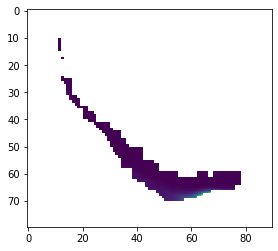

In [33]:
plt.imshow(MAB_5m.pval[180:260,110:200,10])
MAB_cut = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],np.array(MAB_5m.temp[:,:,180:260,110:200])),
                                 'slope': (['lat','lon','depth'], np.array(MAB_5m.slope[180:260,110:200,:])),
                                 'pval': (['lat','lon','depth'], np.array(MAB_5m.pval[180:260,110:200,:])),
                                 'spatgrad':(['depth','lat','lon'], np.array(MAB_5m.spatgrad[:,180:260,110:200]))}, 
                    coords = {'time': glorys.time, 'depth': np.array(MAB_5m.depth), 'lat': np.array(glorys.latitude[180:260]), 'lon': np.array(glorys.longitude[110:200])})

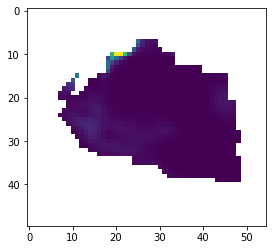

In [48]:
plt.imshow(GOM_5m.pval[250:300,165:220,10])
GOM_cut = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],np.array(GOM_5m.temp[:,:,250:300,165:220])),
                                 'slope': (['lat','lon','depth'], np.array(GOM_5m.slope[250:300,165:220,:])),
                                 'pval': (['lat','lon','depth'], np.array(GOM_5m.pval[250:300,165:220,:])),
                                 'spatgrad':(['depth','lat','lon'], np.array(GOM_5m.spatgrad[:,250:300,165:220]))}, 
                    coords = {'time': glorys.time, 'depth': np.array(GOM_5m.depth), 'lat': np.array(glorys.latitude[250:300]), 'lon': np.array(glorys.longitude[165:220])})

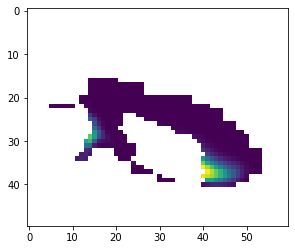

In [55]:
plt.imshow(GB_5m.pval[225:275,175:235,10])
GB_cut = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],np.array(GB_5m.temp[:,:,225:275,175:235])),
                                 'slope': (['lat','lon','depth'], np.array(GB_5m.slope[225:275,175:235,:])),
                                 'pval': (['lat','lon','depth'], np.array(GB_5m.pval[225:275,175:235,:])),
                                 'spatgrad':(['depth','lat','lon'], np.array(GB_5m.spatgrad[:,225:275,175:235]))}, 
                    coords = {'time': glorys.time, 'depth': np.array(GB_5m.depth), 'lat': np.array(glorys.latitude[225:275]), 'lon': np.array(glorys.longitude[175:235])})

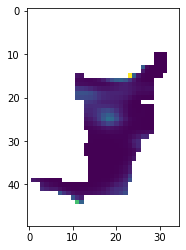

In [17]:
plt.imshow(SS_5m.pval[250:300,200:235,10])
SS_cut = xr.Dataset(data_vars = {'temp': (['time','depth','lat','lon'],np.array(SS_5m.temp[:,:,250:300,200:235])),
                                 'slope': (['lat','lon','depth'], np.array(SS_5m.slope[250:300,200:235,:])),
                                 'pval': (['lat','lon','depth'], np.array(SS_5m.pval[250:300,200:235,:])),
                                 'spatgrad':(['depth','lat','lon'], np.array(SS_5m.spatgrad[:,250:300,200:235]))}, 
                    coords = {'time': glorys.time, 'depth': np.array(SS_5m.depth), 'lat': np.array(glorys.latitude[250:300]), 'lon': np.array(glorys.longitude[200:235])})

In [247]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [248]:
NYB = NYB.to_crs(epsg=4326)

In [249]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [265]:
# Function for cropping data to EPU area
def inSHAPE_all_depth_glorys_slope(longitude, latitude, var, shape):
    x = longitude
    y = latitude
    empty = np.empty(np.shape(var))
    empty[:,:,:] = np.nan
    for i in range(80):
        for j in range(90):
            if Point(x[j], y[i]).within(shape) == True:
                empty[i,j,:] = var[i,j,:]
    return empty

In [275]:
# Function for cropping data to EPU area
def inSHAPE_all_depth_glorys_spatgrad(longitude, latitude, var, shape):
    x = longitude
    y = latitude
    empty = np.empty(np.shape(var))
    empty[:,:,:] = np.nan
    for i in range(80):
        for j in range(90):
            if Point(x[j], y[i]).within(shape) == True:
                empty[:,i,j] = var[:,i,j]
    return empty

In [267]:
NYB_slope = inSHAPE_all_depth_glorys_slope(MAB_cut.lon, MAB_cut.lat, MAB_cut.slope, nyb_shape)

In [269]:
NYB_pval = inSHAPE_all_depth_glorys_slope(MAB_cut.lon, MAB_cut.lat, MAB_cut.pval, nyb_shape)

In [276]:
NYB_spatgrad = inSHAPE_all_depth_glorys_spatgrad(MAB_cut.lon, MAB_cut.lat, MAB_cut.spatgrad, nyb_shape)

In [124]:
import numpy as np
def find_nearest(lat_array, lon_array, lat_value, lon_value):
    #A_array = np.asarray(lat_array)
    #O_array = np.asarray(lon_array)
    idx_la = (np.abs(lat_array - lat_value.values))
    idx_lo = (np.abs(lon_array - lon_value.values))
    idx = np.unravel_index(np.argmin(np.abs(Y - lat_value.values) + np.abs(X - lon_value.values)), Y.shape)
    
    return idx

In [ ]:
import numpy as np
def find_nearest(lat_array, lon_array, lat_value, lon_value):
    #A_array = np.asarray(lat_array)
    #O_array = np.asarray(lon_array)
    idx_la = (np.abs(lat_array - lat_value.values))
    idx_lo = (np.abs(lon_array - lon_value.values))
    idx = np.unravel_index(np.argmin(np.abs(Y - lat_value.values) + np.abs(X - lon_value.values)), Y.shape)
    return idx

In [210]:
def lat_lon_match(line_lat,line_lon, data_lon, data_lat):
    (X,Y) = np.meshgrid(data_lon, data_lat)
    lat_ind = np.empty(len(line_lat))
    lat_ind[:] = np.nan
    lon_ind = np.empty(len(line_lon))
    lon_ind[:] = np.nan
    for i in range(len(lat_ind)):
        [a,b] = find_nearest(Y, X, line_lat[i], line_lon[i])
        lat_ind[i] = a
        lon_ind[i] = b
    return lat_ind, lon_ind

In [212]:
latA, lonA = lat_lon_match(lineA_lat, lineA_lon, MAB_cut.lon, MAB_cut.lat)
latB, lonB = lat_lon_match(lineB_lat, lineB_lon, MAB_cut.lon, MAB_cut.lat)
latC, lonC = lat_lon_match(lineC_lat, lineC_lon, MAB_cut.lon, MAB_cut.lat)
latD, lonD = lat_lon_match(lineD_lat, lineD_lon, MAB_cut.lon, MAB_cut.lat)

latE, lonE = lat_lon_match(lineEgom_lat, lineEgom_lon, GOM_cut.lon, GOM_cut.lat)
latF, lonF = lat_lon_match(lineFgom_lat, lineFgom_lon, GOM_cut.lon, GOM_cut.lat)

latE, lonE = lat_lon_match(lineEgb_lat, lineEgb_lon, GB_cut.lon, GB_cut.lat)
latF, lonF = lat_lon_match(lineFgb_lat, lineFgb_lon, GB_cut.lon, GB_cut.lat)

latG, lonG = lat_lon_match(lineG_lat, lineG_lon, SS_cut.lon, SS_cut.lat)


In [241]:
def TempTrendPlot(lat_index, lon_index, slope_var, pval_var, line_letter, depth):
    Matrix_s = np.empty([59, len(lat_index)])
    Matrix_s[:] = np.nan
    Matrix_p = np.empty([59, len(lat_index)])
    Matrix_p[:] = np.nan
    for j in range(len(lat_index)):
        Matrix_s[:,j] = np.array(slope_var[lat_index[j].astype(int), lon_index[j].astype(int)])
        Matrix_p[:,j] = np.array(slope_var[lat_index[j].astype(int), lon_index[j].astype(int)])
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist[0:len(lat_index),0]/1000, depth[:20], (Matrix_s[:20,:]*12), cmap = 'seismic',  levels = np.arange(0.015, 0.1, 0.005),extend = 'both')
    string = 'DegC/year line ' + line_letter
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    c2 = ax.contourf(dist[0:len(lat_index),0]/1000, depth[:20], Matrix_p[:20,:], hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    #ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

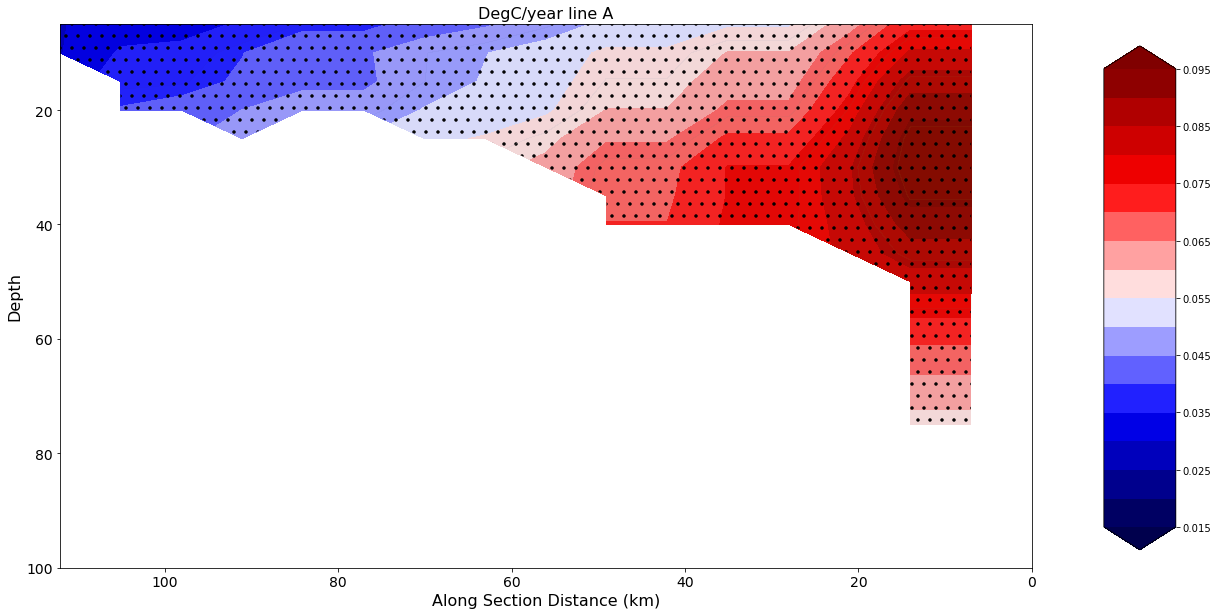

In [242]:
TempTrendPlot(latA, lonA, MAB_cut.slope, MAB_cut.pval, 'A', MAB_cut.depth)


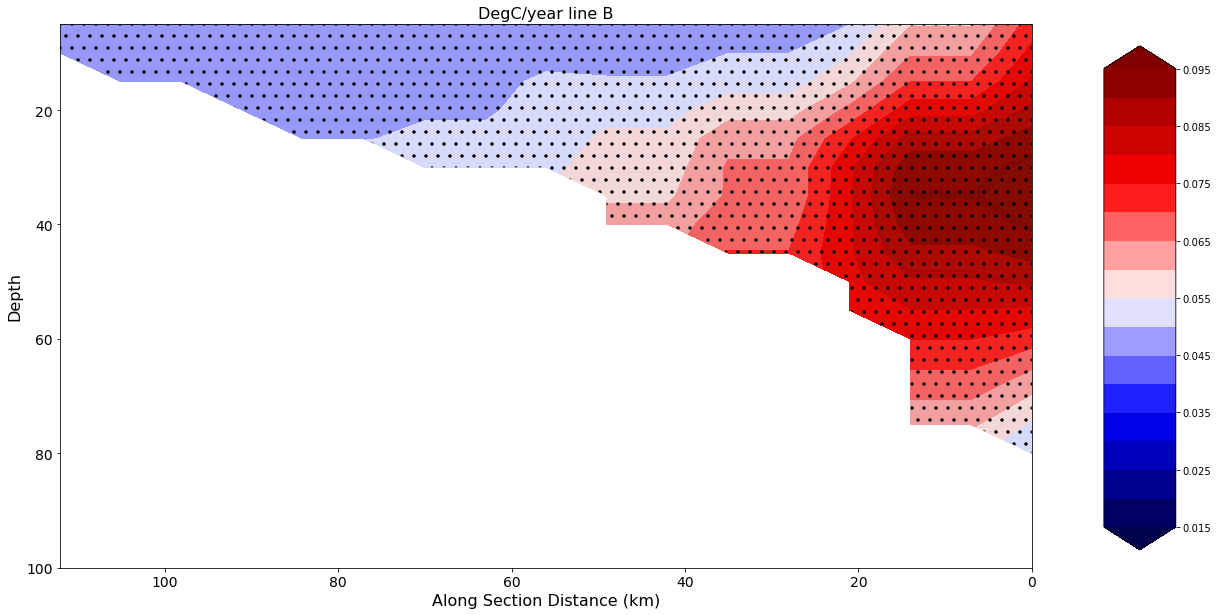

In [243]:
TempTrendPlot(latB, lonB, MAB_cut.slope, MAB_cut.pval, 'B', MAB_cut.depth)

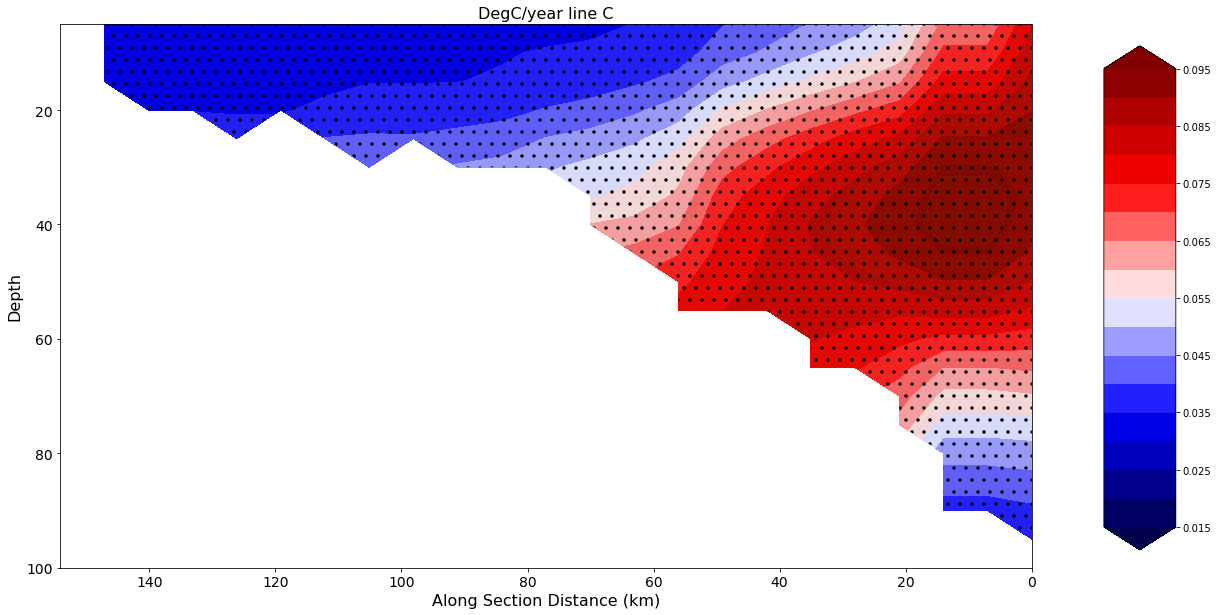

In [244]:
TempTrendPlot(latC, lonC, MAB_cut.slope, MAB_cut.pval, 'C', MAB_cut.depth)

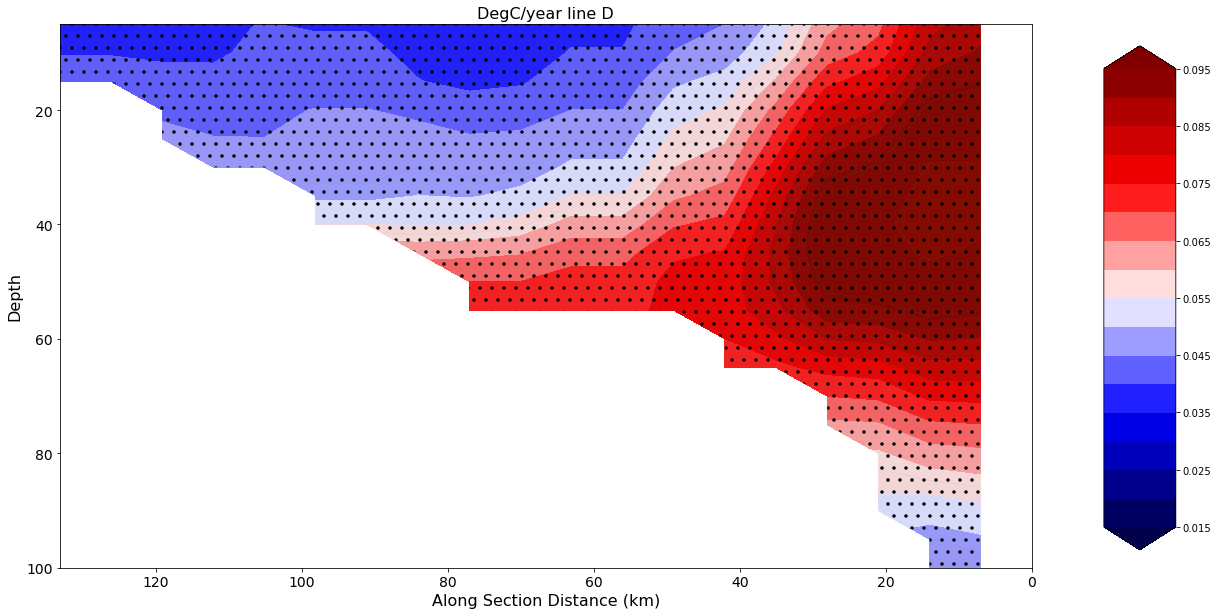

In [245]:
TempTrendPlot(latD, lonD, MAB_cut.slope, MAB_cut.pval, 'D', MAB_cut.depth)

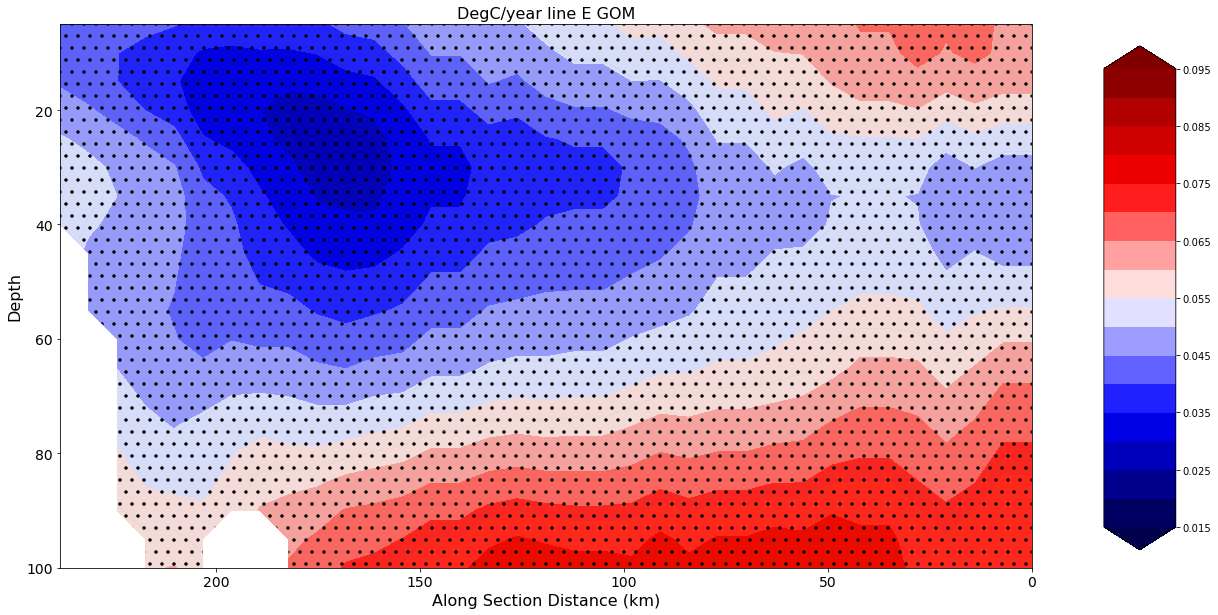

In [463]:
TempTrendPlot(latEgom, lonEgom, GOM_cut.slope, GOM_cut.pval, 'E GOM', GOM_cut.depth)

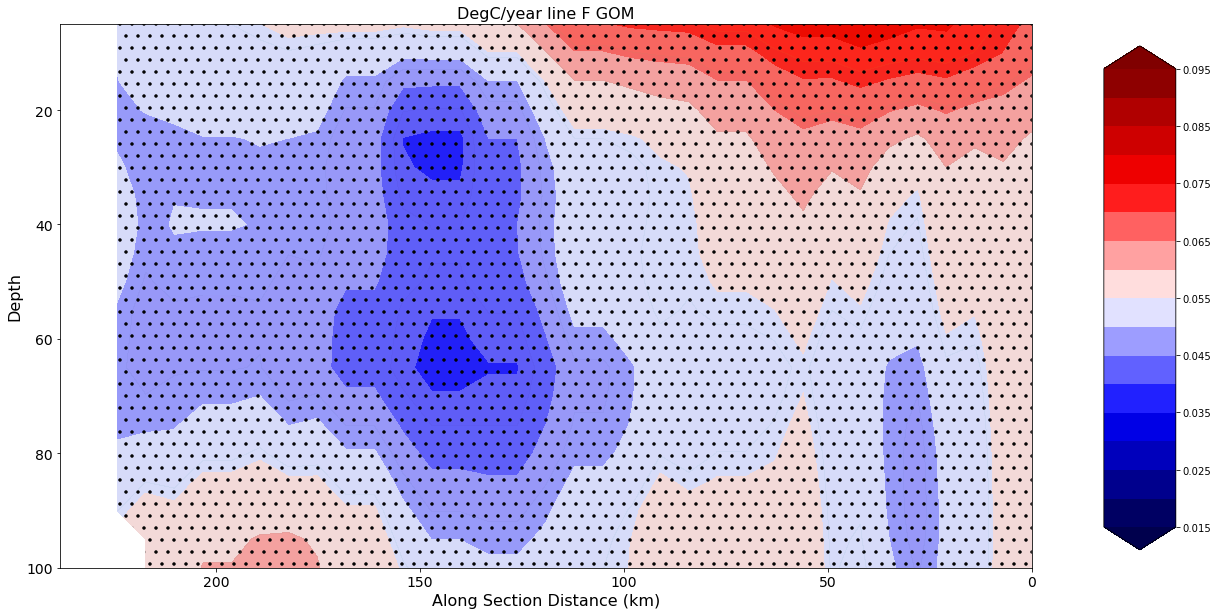

In [464]:
TempTrendPlot(latFgom, lonFgom, GOM_cut.slope, GOM_cut.pval, 'F GOM', GOM_cut.depth)

In [201]:
(X,Y) = np.meshgrid(MAB_cut.lon, MAB_cut.lat)
lat_ind = np.empty(len(lineA_lat))
lat_ind[:] = np.nan
lon_ind = np.empty(len(lineA_lon))
lon_ind[:] = np.nan
for i in range(len(lat_ind)):
    [a,b] = find_nearest(Y, X, lineA_lat[i], lineA_lon[i])
    lat_ind[i] = a
    lon_ind[i] = b
TEST = np.empty([59, len(lat_ind)])
TEST[:] = np.nan
for j in range(len(lat_ind)):
    TEST[:,j] = np.array(MAB_cut.slope[lat_ind[j].astype(int), lon_ind[j].astype(int)])

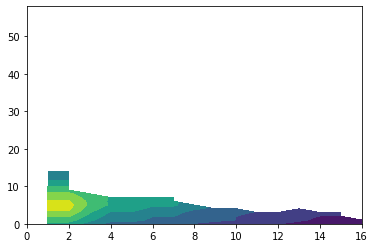

In [204]:
plt.contourf(TEST)

In [ ]:
plt.c

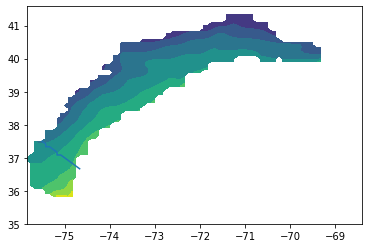

In [202]:
plt.contourf(MAB_cut.lon,MAB_cut.lat,MAB_cut.temp[0,0,:,:])
plt.plot(MAB_cut.lon[lon_ind.astype(int)], MAB_cut.lat[lat_ind.astype(int)])

In [190]:
lineA_lon

<xarray.DataArray 'lon_rho' (eta_rho: 17)>
array([-74.68413 , -74.734242, -74.784415, -74.834649, -74.884945, -74.935302,
       -74.985721, -75.036201, -75.086743, -75.137347, -75.188012, -75.23874 ,
       -75.289529, -75.340381, -75.391295, -75.442271, -75.49331 ])
Coordinates:
    lat_rho  (eta_rho) float64 36.68 36.73 36.78 36.83 ... 37.36 37.41 37.46
    lon_rho  (eta_rho) float64 -74.68 -74.73 -74.78 ... -75.39 -75.44 -75.49
Dimensions without coordinates: eta_rho
Attributes:
    long_name:            longitude of RHO-points
    units:                degrees_east
    standard_name:        longitude
    field:                lon_rho, scalar
    _CoordinateAxisType:  Lon

In [188]:
MAB_cut.lon[lon_ind.astype(int)]

<xarray.DataArray 'lon' (lon: 17)>
array([-74.166664, -74.083336, -74.083336, -74.      , -73.916664, -73.916664,
       -73.833336, -73.833336, -73.75    , -73.75    , -73.666664, -73.583336,
       -73.583336, -73.5     , -73.5     , -73.416664, -73.333336],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -74.17 -74.08 -74.08 -74.0 ... -73.5 -73.42 -73.33

In [167]:
MAB_cut.slope[lat_ind.astype(int),lon_ind.astype(int),50]

<xarray.DataArray 'slope' (lat: 17, lon: 17)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]])
Coordinates:
    depth    int64 255
  * lat      (lat) float32 36.17 36.08 36.08 36.0 ... 35.5 35.42 35.42 35.33
  * lon      (lon) float32 -74.17 -74.08 -74.08 -74.0 ... -73.5 -73.42 -73.33

In [203]:
MAB_cut.slope[lat_ind.astype(int),lon_ind.astype(int),:]

<xarray.DataArray 'slope' (lat: 17, lon: 17, depth: 59)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.00626286, 0.00686472, 0.00742348, ...,        nan,
                nan,        nan],
        [0.00626286, 0.00686472, 0.00742348, ...,        nan,
                nan,        nan],
        ...,
        [0.00313393, 0.00371322, 0.00394862, ...,        nan,
                nan,        nan],
        [0.00313393, 0.00371322, 0.00394862, ...,        nan,
                nan,        nan],
        [0.00281794, 0.0033749 , 0.00364445, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.00612079, 0.00673032, 0.00729616, ...,        nan,
                nan,        nan],
        [0.00612079, 0.00673032, 0.00729616, ...,        nan,
                nan,        nan],
...
        [0.00273489, 0.00296747, 0.0031387 , ...,        nan,
                nan,        nan],
        [0.00273489, 0.00296747, 0.0031387 , ...,        nan,
                nan,        nan],
        [0.00253418, 0.00263049, 0.00272644, ...,        nan,
                nan,        nan]],

       [[0.00431273, 0.00458951, 0.00459049, ...,        nan,
                nan,        nan],
        [0.00409394, 0.00435497, 0.00425867, ...,        nan,
                nan,        nan],
        [0.00409394, 0.00435497, 0.00425867, ...,        nan,
                nan,        nan],
        ...,
        [0.0026624 , 0.00282934, 0.00301406, ...,        nan,
                nan,        nan],
        [0.0026624 , 0.00282934, 0.00301406, ...,        nan,
                nan,        nan],
        [0.00246836, 0.00247531,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * depth    (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat      (lat) float32 36.67 36.75 36.75 36.83 ... 37.33 37.33 37.42 37.5
  * lon      (lon) float32 -74.67 -74.75 -74.75 -74.83 ... -75.42 -75.42 -75.5

In [135]:
lineA_lat[0]

<xarray.DataArray 'lat_rho' ()>
array(36.684164)
Coordinates:
    lat_rho  float64 36.68
    lon_rho  float64 -74.68
Attributes:
    long_name:            latitude of RHO-points
    units:                degrees_north
    standard_name:        latitude
    field:                lat_rho, scalar
    _CoordinateAxisType:  Lat

In [119]:
Y - lineA_lat[0].values

array([[-1.6841621, -1.6841621, -1.6841621, ..., -1.6841621, -1.6841621,
        -1.6841621],
       [-1.6008301, -1.6008301, -1.6008301, ..., -1.6008301, -1.6008301,
        -1.6008301],
       [-1.5174942, -1.5174942, -1.5174942, ..., -1.5174942, -1.5174942,
        -1.5174942],
       ...,
       [ 4.732506 ,  4.732506 ,  4.732506 , ...,  4.732506 ,  4.732506 ,
         4.732506 ],
       [ 4.815838 ,  4.815838 ,  4.815838 , ...,  4.815838 ,  4.815838 ,
         4.815838 ],
       [ 4.89917  ,  4.89917  ,  4.89917  , ...,  4.89917  ,  4.89917  ,
         4.89917  ]], dtype=float32)

In [112]:
ind = np.unravel_index(np.argmin(np.abs(Y - lineA_lat[0].values) + np.abs(X - lineA_lon[0].values)), Y.shape)
ind

Y[ind]
X[ind]
np.where(MAB_cut.lat == Y[ind])
np.where(MAB_cut.lon == X[ind])
ind

(20, 14)

In [91]:
A_array = np.asarray(MAB_cut.lat)
O_array = np.asarray(MAB_cut.lon)
idx_la = (np.abs(A_array - lineA_lat[0].values))
idx_lo = (np.abs(O_array - lineA_lon[0].values))
idx_la + idx_lo

ValueError: operands could not be broadcast together with shapes (80,) (90,) 

In [19]:
def glorys_index(glorys_data, roms_line):
    array = np.array(glorys_data)
    line_ind = np.empty(len(roms_line))
    line_ind[:]=np.nan
    for i in range(len(roms_line)):
        value = roms_line[i].values
        index = find_nearest(array, value)
        line_ind[i]=index
    line_ind = line_ind.astype(int)
    return line_ind

In [56]:
latA = glorys_index(MAB_cut.lat, lineA_lat)
lonA = glorys_index(MAB_cut.lon, lineA_lon)

latB = glorys_index(MAB_cut.lat, lineB_lat)
lonB = glorys_index(MAB_cut.lon, lineB_lon)

latC = glorys_index(MAB_cut.lat, lineC_lat)
lonC = glorys_index(MAB_cut.lon, lineC_lon)

latD = glorys_index(MAB_cut.lat, lineD_lat)
lonD = glorys_index(MAB_cut.lon, lineD_lon)

latEgom = glorys_index(GOM_cut.lat, lineEgom_lat)
lonEgom = glorys_index(GOM_cut.lon, lineEgom_lon)

latFgom = glorys_index(GOM_cut.lat, lineFgom_lat)
lonFgom = glorys_index(GOM_cut.lon, lineFgom_lon)

latEgb = glorys_index(GB_cut.lat, lineEgb_lat)
lonEgb = glorys_index(GB_cut.lon, lineEgb_lon)

latFgb = glorys_index(GB_cut.lat, lineFgb_lat)
lonFgb = glorys_index(GB_cut.lon, lineFgb_lon)

latG = glorys_index(SS_cut.lat, lineG_lat)
lonG = glorys_index(SS_cut.lon, lineG_lon)

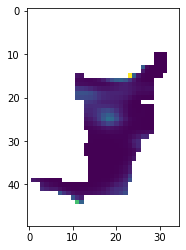

In [36]:
plt.imshow(SS_5m.pval[250:300,200:235,10])

In [22]:
SS_cut

<xarray.Dataset>
Dimensions:   (depth: 59, lat: 50, lon: 35, time: 329)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
  * depth     (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat       (lat) float32 40.83 40.92 41.0 41.08 ... 44.67 44.75 44.83 44.92
  * lon       (lon) float32 -68.33 -68.25 -68.17 -68.08 ... -65.67 -65.58 -65.5
Data variables:
    temp      (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan
    slope     (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    spatgrad  (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [58]:
SSpval_yn = np.empty([50,35,59])
SSpval_yn[:,:,:] = np.nan
for i in range(50):
    for j in range(35):
        for k in range(59):
            if SS_cut.pval[i,j,k] <= 0.05:
                SSpval_yn[i,j,k] == 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [60]:
MAB_cut

<xarray.Dataset>
Dimensions:   (depth: 59, lat: 80, lon: 90, time: 329)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
  * depth     (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat       (lat) float32 35.0 35.08 35.17 35.25 ... 41.33 41.42 41.5 41.58
  * lon       (lon) float32 -75.83 -75.75 -75.67 -75.58 ... -68.58 -68.5 -68.42
Data variables:
    temp      (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan
    slope     (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    spatgrad  (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [448]:
MABpval_yn = np.empty([80,90,59])
MABpval_yn[:,:,:] = np.nan
for i in range(80):
    for j in range(90):
        for k in range(59):
            if MAB_cut.pval[i,j,k] <= 0.05:
                MABpval_yn[i,j,k] == 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [63]:
GB_cut

<xarray.Dataset>
Dimensions:   (depth: 59, lat: 50, lon: 60, time: 329)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
  * depth     (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat       (lat) float32 38.75 38.83 38.92 39.0 ... 42.58 42.67 42.75 42.83
  * lon       (lon) float32 -70.42 -70.33 -70.25 -70.17 ... -65.67 -65.58 -65.5
Data variables:
    temp      (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan
    slope     (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    spatgrad  (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [64]:
GBpval_yn = np.empty([50,60,59])
GBpval_yn[:,:,:] = np.nan
for i in range(50):
    for j in range(60):
        for k in range(59):
            if GB_cut.pval[i,j,k] <= 0.05:
                GBpval_yn[i,j,k] == 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [65]:
GOM_cut

<xarray.Dataset>
Dimensions:   (depth: 59, lat: 50, lon: 55, time: 329)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
  * depth     (depth) int64 5 10 15 20 25 30 35 ... 265 270 275 280 285 290 295
  * lat       (lat) float32 40.83 40.92 41.0 41.08 ... 44.67 44.75 44.83 44.92
  * lon       (lon) float32 -71.25 -71.17 -71.08 -71.0 ... -66.92 -66.83 -66.75
Data variables:
    temp      (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan
    slope     (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (lat, lon, depth) float64 nan nan nan nan nan ... nan nan nan nan
    spatgrad  (depth, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [67]:
GOMpval_yn = np.empty([50,55,59])
GOMpval_yn[:,:,:] = np.nan
for i in range(50):
    for j in range(55):
        for k in range(59):
            if GOM_cut.pval[i,j,k] <= 0.05:
                GOMpval_yn[i,j,k] == 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
def TempTrendPlot_G(lat_ind, lon_ind, slope_var, pval_var, line_letter):

    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist[0:len(lat_ind),0]/1000, -1*glorys.depth2[40:-1], (slope_var[lat_ind,lon_ind,40:-1]*12).T, cmap = 'seismic',  levels = np.arange(0.05, 0.28, 0.01),extend = 'both')
    string = 'DegC/year line ' + line_letter
    plt.gca().invert_yaxis()
    c2 = ax.contourf(dist[0:len(lat_ind),0]/1000, -1*glorys.depth2[40:-1], pval_yn[lat_ind,lon_ind,40:-1].T, hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.set_xlim(0,dist[len(lat_ind),0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

In [ ]:
TempTrendPlot_G(latG, lonG,SS_5m.slope, SS_5m.pval, "g")

In [ ]:
#fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
pval_yn = SS_cut.pval
pval_yn[np.where(pval_yn>0.05)] = np.nan
pval_yn[np.where(pval_yn<=0.05)] = 1

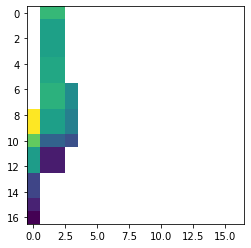

In [76]:
plt.imshow(MAB_cut.slope[lat_ind,lon_ind,10])

TypeError: Input z must be 2D, not 3D

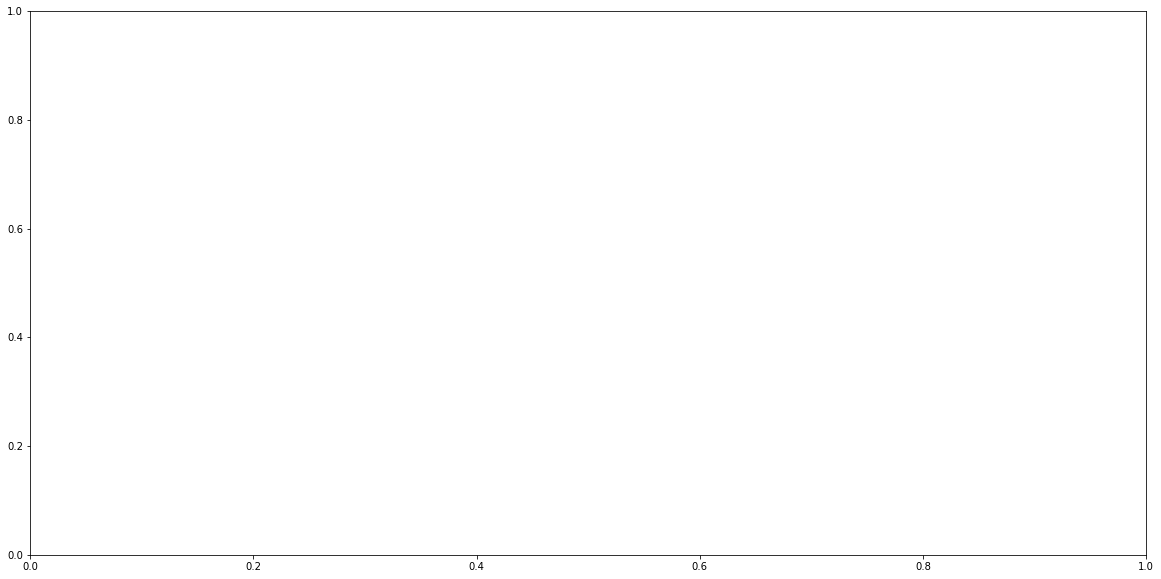

In [73]:
lat_ind = latA
lon_ind = lonA
slope_var = MAB_cut.slope
fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
c = ax.contourf(dist[0:len(lat_ind),0]/1000, -1*MAB_cut.depth[40:-1], (slope_var[lat_ind,lon_ind,40:-1]*12).T, cmap = 'seismic',  levels = np.arange(0.05, 0.28, 0.01),extend = 'both')

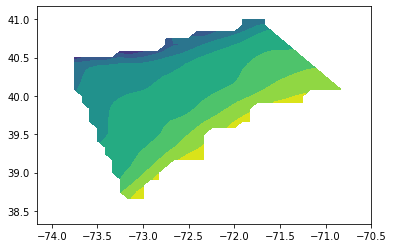

In [298]:
plt.contourf(MAB_cut.lon[20:65], MAB_cut.lat[40:75], NYB_spatgrad[0,40:75,20:65])

In [458]:
np.shape(NYB_pval)

(80, 90, 59)

In [459]:
NYBpval_yn = np.empty([80,90,59])
NYBpval_yn[:,:,:] = np.nan
for i in range(80):
    for j in range(90):
        for k in range(59):
            if NYB_pval[i,j,k] <= 0.05:
                NYBpval_yn[i,j,k] == 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


/Users/nyelab/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/nyelab/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


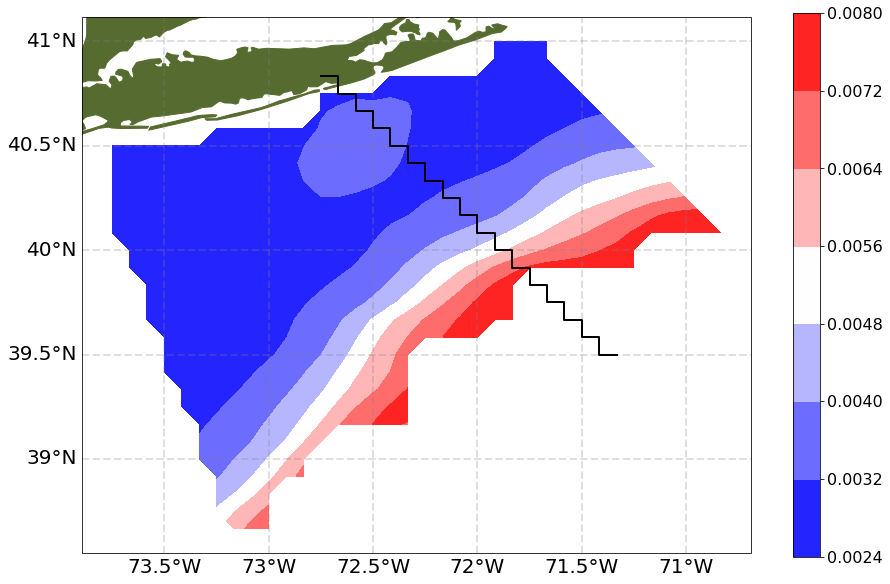

In [443]:
fig, ax = plt.subplots(figsize = [15,10],subplot_kw={'projection': ccrs.PlateCarree()})
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.25, linestyle='--')
ax.add_feature(cartopy.feature.LAND)
c = plt.contourf(MAB_cut.lon[20:65], MAB_cut.lat[40:75], NYB_slope[40:75,20:65,0],cmap = 'bwr')
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
cb = plt.colorbar(c)
cb.ax.tick_params(labelsize=16) 
gl.xlabels_top = False
gl.xlabel_style = {'size': 20, 'color': 'k'}
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
plt.plot(MAB_cut.lon[lon_inds], MAB_cut.lat[lat_indicies],linewidth = 2, c='k')
#plt.plot(roms.lon_rho[55,:], roms.lat_rho[55,:],linewidth = 2, c='k')

In [444]:
MAB_cut.lat[54:70]

<xarray.DataArray 'lat' (lat: 16)>
array([39.5     , 39.583332, 39.666668, 39.75    , 39.833332, 39.916668,
       40.      , 40.083332, 40.166668, 40.25    , 40.333332, 40.416668,
       40.5     , 40.583332, 40.666668, 40.75    ], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.5 39.58 39.67 39.75 ... 40.5 40.58 40.67 40.75

In [326]:
indicies = np.arange(54,71)

In [328]:
lat_indicies = np.sort(np.append(indicies,indicies))

In [346]:
inds = np.arange(37,54)

In [354]:
lon_inds = -np.sort(-np.append(inds,inds))

In [356]:
lon_inds = lon_inds[:-1]

In [358]:
lon_inds = np.append(54, lon_inds)

In [359]:
lon_inds

array([54, 53, 53, 52, 52, 51, 51, 50, 50, 49, 49, 48, 48, 47, 47, 46, 46,
       45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37])

In [357]:
lon_inds

array([53, 53, 52, 52, 51, 51, 50, 50, 49, 49, 48, 48, 47, 47, 46, 46, 45,
       45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37])

In [364]:
dist2 = np.arange(0, 9.25*17*2,9.25)

In [365]:
dist2

array([  0.  ,   9.25,  18.5 ,  27.75,  37.  ,  46.25,  55.5 ,  64.75,
        74.  ,  83.25,  92.5 , 101.75, 111.  , 120.25, 129.5 , 138.75,
       148.  , 157.25, 166.5 , 175.75, 185.  , 194.25, 203.5 , 212.75,
       222.  , 231.25, 240.5 , 249.75, 259.  , 268.25, 277.5 , 286.75,
       296.  , 305.25])

In [451]:
def TempTrendPlotnyb(lat_index, lon_index, slope_var, pval_var, depth):
    Matrix_s = np.empty([59, len(lat_indicies)])
    Matrix_s[:] = np.nan
    Matrix_p = np.empty([59, len(lat_indicies)])
    Matrix_p[:] = np.nan
    for j in range(len(lat_indicies)):
        Matrix_s[:,j] = np.array(slope_var[lat_indicies[j].astype(int), lon_inds[j].astype(int),:])
        Matrix_p[:,j] = np.array(pval_var[lat_indicies[j].astype(int), lon_index[j].astype(int),:])
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist2[10:-2], depth[:20], (Matrix_s[:20,10:-2]*12), cmap = 'seismic',  levels = np.arange(0.015, 0.1, 0.005),extend = 'both')
    string = 'DegC/year'
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    c2 = ax.contourf(dist2[10:-2], depth[:20], Matrix_p[:20,10:-2], hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    #ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

In [449]:
def SpatGradPlotnyb(lat_index, lon_index, spatgrad_var, depth):
    Matrix_s = np.empty([59, len(lat_indicies)])
    Matrix_s[:] = np.nan
    for j in range(len(lat_indicies)):
        Matrix_s[:,j] = np.array(spatgrad_var[:,lat_indicies[j].astype(int), lon_inds[j].astype(int)])
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist2[10:-2], depth[:20], (Matrix_s[:20,10:-2]*12), cmap = 'viridis', levels = np.arange(-5.6, 1.8, 0.5),extend = 'both')
    c2 = ax.contour(dist2[10:-2], depth[:20], (Matrix_s[:20,10:-2]*12), levels = [0])
    string = 'DegC/m'
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    #c2 = ax.contourf(dist2[10:-2], depth[:20], Matrix_p[:20,10:-2], hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    #ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

0.48748873311129537

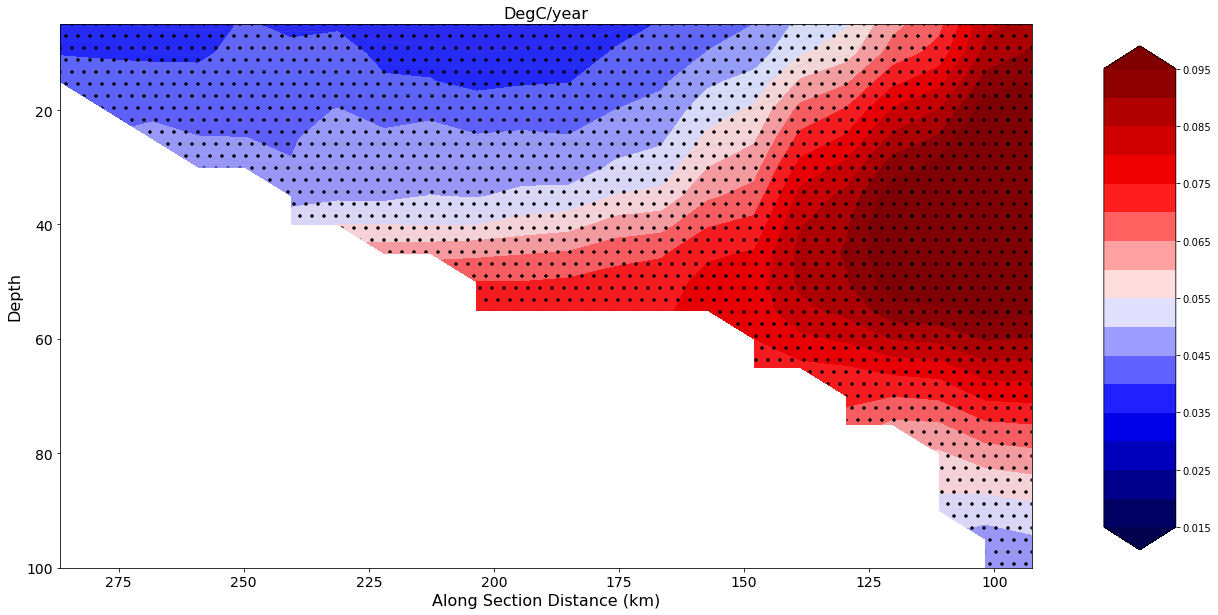

In [460]:
TempTrendPlotnyb(lat_indicies,lon_inds,NYB_slope,NYB_pval,MAB_cut.depth)

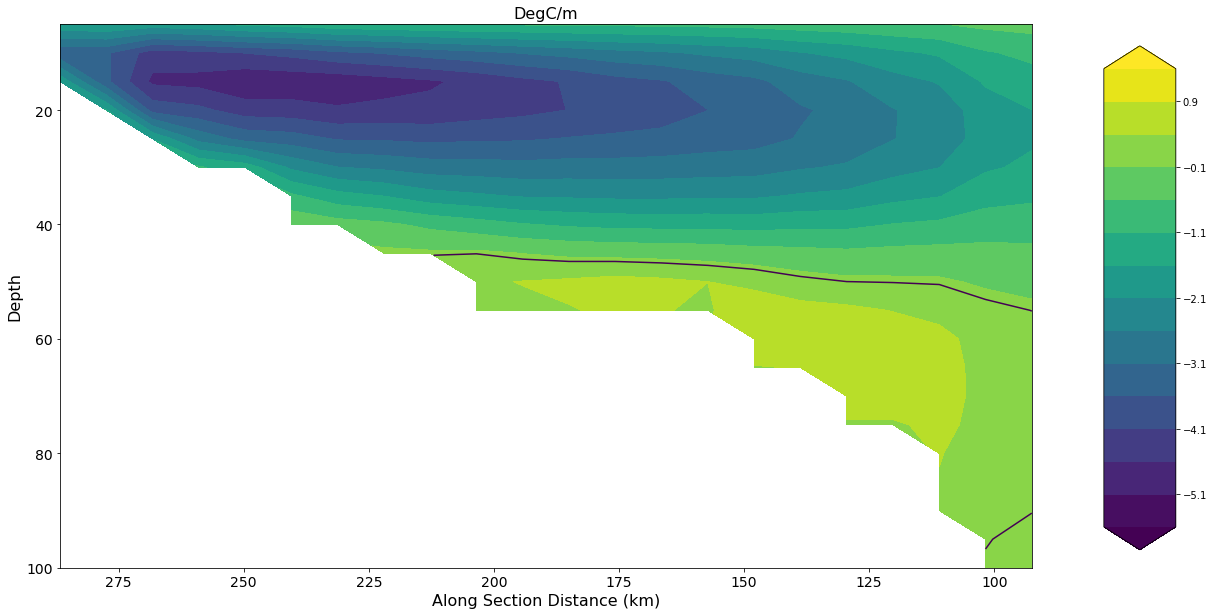

In [415]:
SpatGradPlotnyb(lat_indicies,lon_inds,NYB_spatgrad,MAB_cut.depth)

In [439]:
def ClimVelPlotnyb(lat_index, lon_index, slope_var, spatgrad_var, depth):
    Matrix_s = np.empty([59, len(lat_indicies)])
    Matrix_s[:] = np.nan
    Matrix_g = np.empty([59, len(lat_indicies)])
    Matrix_g[:] = np.nan
    for j in range(len(lat_indicies)):
        Matrix_s[:,j] = np.array(slope_var[lat_indicies[j].astype(int), lon_inds[j].astype(int),:])
        Matrix_g[:,j] = np.array(spatgrad_var[:,lat_indicies[j].astype(int), lon_inds[j].astype(int)])
    fig,ax = plt.subplots(nrows = 1, figsize = [20,10])
    c = ax.contourf(dist2[10:-2], depth[:20], (Matrix_s[:20,10:-2]*12)/(Matrix_g[:20,10:-2]), cmap = 'magma_r', levels = np.append(np.arange(-2,0,0.2), np.arange(0,5,1)), extend='both')
    string = 'm/year'
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    #c2 = ax.contourf(dist[0:len(lat_index),0]/1000, depth[:20], Matrix_p[:20,:], hatches=['.'],alpha=0.05)
    ax.set_title(string,fontsize = 16)
    ax.set_ylabel('Depth',fontsize = 16)
    ax.set_xlabel('Along Section Distance (km)',fontsize = 16)
    ax.tick_params(labelsize = 14)
    #ax.set_xlim(dist[i,0]/1000,dist[k,0]/1000)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax)

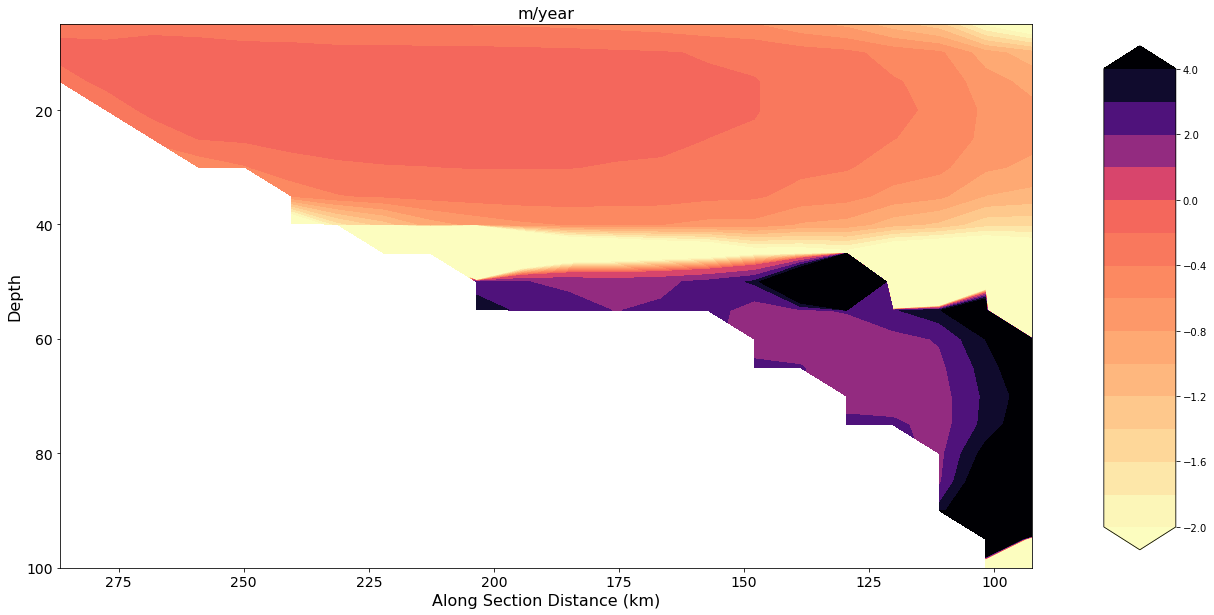

In [440]:
ClimVelPlotnyb(lat_indicies,lon_inds,NYB_slope,NYB_spatgrad,MAB_cut.depth)

In [447]:
glorys.time[-1]

<xarray.DataArray 'time' ()>
array('2020-05-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-05-16T12:00:00
Attributes:
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    _CoordinateAxisType:  Time
    valid_min:            377316.0
    valid_max:            437916.0

In [428]:
Matrix_s = np.empty([59, len(lat_indicies)])
Matrix_s[:] = np.nan
Matrix_g = np.empty([59, len(lat_indicies)])
Matrix_g[:] = np.nan
for j in range(len(lat_indicies)):
    Matrix_s[:,j] = np.array(NYB_slope[lat_indicies[j].astype(int), lon_inds[j].astype(int),:])
    Matrix_g[:,j] = np.array(NYB_spatgrad[:,lat_indicies[j].astype(int), lon_inds[j].astype(int)])

In [434]:
np.nanmin(Matrix_s/Matrix_g)

-27.847888608386352